In [1]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = {# U_L/du
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144804252876,0.00974592070867],
2.0:[0.142805206381,0.0110827643436],
}
U_L = {}
for key in du.keys():
    U_L[key] = key*du[key][0]

def get_TKEB(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    d = {}
    d['R11'] = dat[:,0]
    d['R12'] = dat[:,1]
    d['R22'] = dat[:,3]  
    return d#R11,R12,R22

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*TKEBudget_0*h5")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 150.0x200.0x75.0
['TKEBudget_0000.h5', 'TKEBudget_0002.h5', 'TKEBudget_0004.h5', 'TKEBudget_0006.h5', 'TKEBudget_0008.h5', 'TKEBudget_0010.h5', 'TKEBudget_0011.h5', 'TKEBudget_0012.h5']


production={
0.2: [0.147334777253,0.000933605266898],
0.4: [0.173912857414,0.0],
0.8: [0.699373758412,0.105702048439],
1.2: [0.966950835888,0.055655292007],
1.6: [1.04951162925,0.1891942401],
2.0: [0.769724852976,0.0197967872132],
}
dissipation={
0.2: [0.0993096840104,0.00089153070699],
0.4: [0.12973305112,0.0],
0.8: [0.524800889808,0.0367718294889],
1.2: [0.713141983954,0.0661824890104],
1.6: [0.815464637126,0.0977219083703],
2.0: [0.424232654865,0.00309448529585],
}


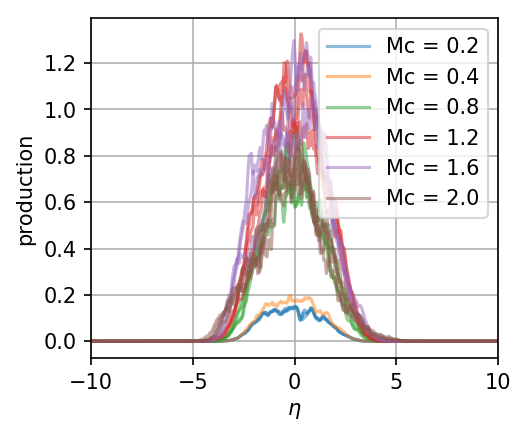

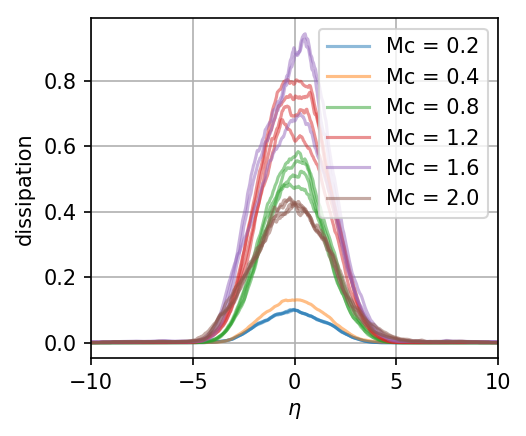

In [189]:
#### s = '1'
# Mc_list = ['02','08','20']
Mc_list = ['02','04','08','12','16','20']

for statname in ['production',]:
    print(statname+'={')
    fig = plt.figure(figsize=(3.5,3),dpi=150)
    for i,Mc in enumerate(Mc_list):
        directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_') 
        
        flist = glob.glob(directory+"*TKEBudget_0*h5")
        flist.sort()

        if Mc=='02': ist=5;ien=None
        elif Mc=='04': ist=4;ien=-1
#         elif Mc=='04': ist=-2;ien=-1
        elif Mc=='12': ist=-5;ien=-1
        elif Mc=='16': ist=-6;ien=-3
        else: ist = -4; ien=None
    
        mat = np.zeros(len(flist[ist:ien]))
        for j,fname in enumerate(flist[ist:ien]):
            hf = h5py.File(fname,'r')
            time = hf.attrs['Time'][0]
            stat = np.squeeze(hf[statname])
            #if statname=='dissipation':
            #    if time==1000 and inp.Mc==0.2: pass
            #    else: stat += np.squeeze(hf[statname+'_num'])
            
            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta

            #scale = 1./inp.du**3
            #scale = 1./U_L[inp.Mc]**3
            scale = 1./(U_L[inp.Mc]*inp.dU**2)
            fplot = stat*scale
    
            if j==0: plt.plot(eta,fplot,color='C%i'%i,alpha=0.5,label='Mc = {}'.format(inp.Mc))
            else: plt.plot(eta,fplot,color='C%i'%i,alpha=0.5)
            mat[j] = fplot[Ny/2]
        print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[:]),np.std(mat[:])))

        
    plt.xlim([-10,10])
    plt.xlabel(r'$\eta$')
    plt.ylabel(statname)
    plt.legend()
    plt.grid(True)
    print('}')
    

Text(0.5,0,'$M_c$')

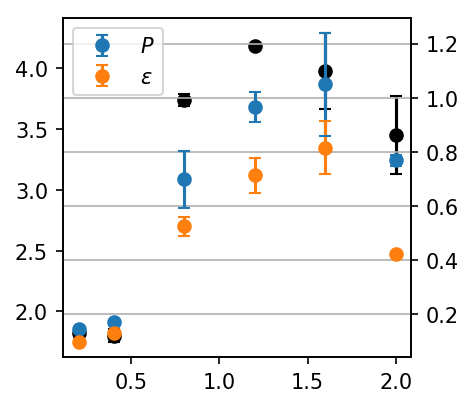

In [191]:

def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(tke,'ko','k')
plt.twinx()
plotter(production,'o','$P$')
plotter(dissipation,'o','$\epsilon$')

# plt.ylabel(r'$R_{ij}$')
plt.grid(True)
plt.legend()#bbox_to_anchor=(1, 0.75))
plt.xlabel('$M_c$')

In [190]:
# scaled by U_L
tke={
0.2: [1.82614607331,0.0357854416898],
0.4: [1.80137157563,0.0524669032337],
0.8: [3.74034227339,0.0521491298081],
1.2: [4.1808155672,0.0221752675731],
1.6: [3.97907598147,0.311855511634],
2.0: [3.45045419989,0.321710450359],
}
production={
0.2: [0.147334777253,0.000933605266898],
0.4: [0.173912857414,0.0],
0.8: [0.699373758412,0.105702048439],
1.2: [0.966950835888,0.055655292007],
1.6: [1.04951162925,0.1891942401],
2.0: [0.769724852976,0.0197967872132],
}
dissipation={
0.2: [0.0993096840104,0.00089153070699],
0.4: [0.12973305112,0.0],
0.8: [0.524800889808,0.0367718294889],
1.2: [0.713141983954,0.0661824890104],
1.6: [0.815464637126,0.0977219083703],
2.0: [0.424232654865,0.00309448529585],
}

In [181]:
#scaled by dU^2
tke={
0.2: [0.0335760090082,0.000657960680199],
0.4: [0.0266054162004,0.000774911637422],
0.8: [0.021557000133,0.000300555060484],
1.2: [0.0172861381655,9.1686593911e-05],
1.6: [0.0148989903749,0.00116769126496],
2.0: [0.0125654001235,0.0011715618578],
}
production={
0.2: [0.000367320874225,2.32757471936e-06],
0.4: [0.000312163281932,0.0],
0.8: [0.000306002377629,4.62486299398e-05],
1.2: [0.000257075002589,1.47965995848e-05],
1.6: [0.000240463501234,4.33480755429e-05],
2.0: [0.000169155293271,4.35055635e-06],
}
dissipation={
0.2: [0.000247589337899,2.22267847954e-06],
0.4: [0.000232863145456,0.0],
0.8: [0.000229620168231,1.60890612752e-05],
1.2: [0.00018959699973,1.75953760028e-05],
1.6: [0.000186838788929,2.23899874752e-05],
2.0: [9.32296766452e-05,6.80046338269e-07],
}